In [31]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import datetime # manipulating date formats
import holidays
import IPython
import IPython.display


from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from torch.autograd import Variable

# settings
plt.style.use('seaborn-deep')

import concurrent.futures
import requests
import time
from functools import partial
from datetime import datetime
import os
import warnings
warnings.filterwarnings(action='ignore')
import holidays
from sklearn.preprocessing import MinMaxScaler
import random

from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
from torch.autograd import Variable

import torch
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
import copy
from sklearn.cluster import KMeans

In [32]:
ts = pd.read_csv("hourly.csv", parse_dates=['timestamp'])
ts = ts.drop(['Unnamed: 0','reportingGroup','unit'],axis=1)
ts

,timestamp,locationName,value
0,2019-01-01 00:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
1,2019-01-01 01:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
2,2019-01-01 02:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
3,2019-01-01 03:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
4,2019-01-01 04:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
...,...,...,...
1184945,2019-03-31 23:20:00,4661 Kalasataman TeHyKe,0.00
1184946,2019-03-31 23:30:00,4661 Kalasataman TeHyKe,22.00
1184947,2019-03-31 23:40:00,4661 Kalasataman TeHyKe,0.00
1184948,2019-03-31 23:50:00,4661 Kalasataman TeHyKe,22.25


用于划分出100个client加和起来的测试集

In [42]:
ts_total = pd.read_csv("hourly_total.csv", parse_dates=['timestamp'], index_col=['timestamp'])
ts_total

,kWh
timestamp,
2019-01-01 00:00:00,11865.25
2019-01-01 01:00:00,11898.05
2019-01-01 02:00:00,11741.78
2019-01-01 03:00:00,11662.78
2019-01-01 04:00:00,11986.15
...,...
2019-03-31 20:00:00,13619.95
2019-03-31 21:00:00,13476.02
2019-03-31 22:00:00,12665.50


# 按照cluster的思路给每个client分数据

求和

In [35]:
client_n = 100
cluster_n = min(2, int(ts.locationName.nunique()/client_n))

user_name = ts.locationName.unique().tolist()
clients = []

for i in range(client_n):
    clients.append(user_name[i*cluster_n:(i+1)*cluster_n]) 
    
ts['client_id'] = 0
ts_new = pd.DataFrame(columns=ts.columns)
for i in range(client_n):
    for j in range(cluster_n):
        tmp = ts.loc[ts['locationName'] == clients[i][j]]
        tmp['client_id'] = i
        ts_new = pd.concat([ts_new, tmp])

ts_agg = pd.DataFrame(columns=ts_new.columns)
for i in range(client_n):
    tmp = ts_new.loc[ts_new['client_id'] == i].groupby('timestamp')['value'].apply(sum).to_frame()
    tmp['client_id'] = i
    ts_agg = pd.concat([ts_agg, tmp])
ts_agg = ts_agg.drop(['timestamp', 'locationName'],axis=1)
ts_agg = ts_agg.rename(columns={'value':'kWh'})
ts = ts_agg
ts

,kWh,client_id
2019-01-01 00:00:00,0.00,0
2019-01-01 01:00:00,0.00,0
2019-01-01 02:00:00,0.00,0
2019-01-01 03:00:00,0.00,0
2019-01-01 04:00:00,0.00,0
...,...,...
2019-03-31 20:00:00,106.42,99
2019-03-31 21:00:00,111.93,99
2019-03-31 22:00:00,112.93,99
2019-03-31 23:00:00,112.08,99


加特征

In [45]:
# begin = '2017-01-01'
# end = '2019-12-31'
begin = '2019-01-01'
end = '2019-04-01'
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:end])

exo = ts.copy()
exo_total = ts_total.copy()

exo["holidays"] = 0
exo_total["holidays"] = 0

exo.loc[hol] = 1
exo.loc["2020-01-01","holidays"] = 1
exo_total.loc[hol] = 1
exo_total.loc["2020-01-01","holidays"] = 1

ts["holidays"] = exo["holidays"]
ts_total["holidays"] = exo_total["holidays"]

date = ts.index
timestamp_s = date.map(datetime.timestamp)
week = 7*24*60*60
ts['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
ts['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
ts = ts[['kWh', 'Week sin', 'Week cos', 'holidays', 'client_id']]


date = ts_total.index
timestamp_s = date.map(datetime.timestamp)
week = 7*24*60*60
ts_total['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
ts_total['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
ts_total = ts_total[['kWh', 'Week sin', 'Week cos', 'holidays']]

ts_total

,kWh,Week sin,Week cos,holidays
timestamp,,,,
2019-01-01 00:00:00,11865.25,-8.660254e-01,-0.500000,1.0
2019-01-01 01:00:00,11898.05,-8.841154e-01,-0.467269,0.0
2019-01-01 02:00:00,11741.78,-9.009689e-01,-0.433884,0.0
2019-01-01 03:00:00,11662.78,-9.165623e-01,-0.399892,0.0
2019-01-01 04:00:00,11986.15,-9.308737e-01,-0.365341,0.0
...,...,...,...,...
2019-03-31 20:00:00,13619.95,-1.913309e-13,-1.000000,0.0
2019-03-31 21:00:00,13476.02,-3.739119e-02,-0.999301,0.0
2019-03-31 22:00:00,12665.50,-7.473009e-02,-0.997204,0.0


归一化

In [46]:
for i in range(client_n):
    scaler = MinMaxScaler(feature_range=(0, 1))
    if i == 0:
        norm = scaler.fit_transform(ts.loc[ts['client_id']==i][['kWh','Week sin','Week cos']])
        nonnorm = ts.loc[ts['client_id']==i][['holidays', 'client_id']]
        ts_normalized = pd.DataFrame(np.concatenate([norm,nonnorm], axis=1),
                                 columns = ts.columns.values,
                                index = ts.loc[ts['client_id']==i].index)
    else:
        norm = scaler.fit_transform(ts.loc[ts['client_id']==i][['kWh','Week sin','Week cos']])
        nonnorm = ts.loc[ts['client_id']==i][['holidays', 'client_id']]
        ts_normalized = pd.concat([ts_normalized, pd.DataFrame(np.concatenate([norm,nonnorm], axis=1),
                                 columns = ts.columns.values,
                                index = ts.loc[ts['client_id']==i].index)])
        
scaler_kwh_total = MinMaxScaler(feature_range=(0, 1)).fit(ts_total[["kWh"]])
ts_total_normalized = pd.DataFrame(scaler.fit_transform(ts_total),
                             columns = ts_total.columns.values,
                            index = ts_total.index)
ts_normalized

,kWh,Week sin,Week cos,holidays,client_id
2019-01-01 00:00:00,0.0,0.066987,0.25,1,0
2019-01-01 01:00:00,0.0,0.057942,0.266366,0,0
2019-01-01 02:00:00,0.0,0.049516,0.283058,0,0
2019-01-01 03:00:00,0.0,0.041719,0.300054,0,0
2019-01-01 04:00:00,0.0,0.034563,0.317329,0,0
...,...,...,...,...,...
2019-03-31 20:00:00,0.097975,0.5,0.0,0,99
2019-03-31 21:00:00,0.125185,0.481304,0.00035,0,99
2019-03-31 22:00:00,0.130123,0.462635,0.001398,0,99
2019-03-31 23:00:00,0.125926,0.444018,0.003144,0,99


# 聚类

In [6]:
kmeans_cluster_n = 5
for i in range(client_n):
    if i == 0:
        ts_array = np.expand_dims(np.squeeze(ts_normalized.loc[ts_normalized['client_id']==i][['kWh']][:1500].values), axis=0)
    else:
        ts_array = np.concatenate([ts_array, np.expand_dims(np.squeeze(ts_normalized.loc[ts_normalized['client_id']==i][['kWh']][:1500].values), axis=0)], axis=0)
kmeans = KMeans(n_clusters=kmeans_cluster_n, random_state=0).fit(ts_array)
kmeans.labels_

array([3, 0, 4, 1, 0, 0, 1, 0, 0, 1, 4, 0, 1, 4, 0, 0, 0, 3, 2, 2, 4, 3,
       3, 2, 2, 3, 4, 1, 1, 0, 4, 2, 4, 3, 3, 2, 3, 3, 3, 3, 1, 4, 2, 1,
       1, 2, 0, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 3, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 0, 4, 4, 0, 1,
       1, 1, 0, 1, 0, 3, 1, 1, 0, 3, 3, 3], dtype=int32)

In [19]:
ts_normalized['cluster'] = 0

for i in range(client_n):
    for j in range(kmeans_cluster_n):
        if kmeans.labels_[i] == j:
            ts_normalized.loc[ts_normalized.client_id==i, 'cluster'] = j
ts_normalized

,kWh,Week sin,Week cos,holidays,client_id,cluster
2019-01-01 00:00:00,0.0,0.066987,0.25,1,0,3
2019-01-01 01:00:00,0.0,0.057942,0.266366,0,0,3
2019-01-01 02:00:00,0.0,0.049516,0.283058,0,0,3
2019-01-01 03:00:00,0.0,0.041719,0.300054,0,0,3
2019-01-01 04:00:00,0.0,0.034563,0.317329,0,0,3
...,...,...,...,...,...,...
2019-03-31 20:00:00,0.097975,0.5,0.0,0,99,3
2019-03-31 21:00:00,0.125185,0.481304,0.00035,0,99,3
2019-03-31 22:00:00,0.130123,0.462635,0.001398,0,99,3
2019-03-31 23:00:00,0.125926,0.444018,0.003144,0,99,3


# 划分数据集

In [47]:
train_end = '2019-03-17'
val_end = '2019-03-24'
test_end = '2019-04-01'
demo_start = '2019-03-25'

test_df = ts_normalized[val_end:]
train_df = ts_normalized[:train_end]
val_df = ts_normalized[train_end:val_end]
total_df = ts_total_normalized

column_indices = {name: i for i, name in enumerate(ts.columns)}
num_features = ts.shape[1]
train_df

,kWh,Week sin,Week cos,holidays,client_id
2019-01-01 00:00:00,0.0,0.066987,0.25,1,0
2019-01-01 01:00:00,0.0,0.057942,0.266366,0,0
2019-01-01 02:00:00,0.0,0.049516,0.283058,0,0
2019-01-01 03:00:00,0.0,0.041719,0.300054,0,0
2019-01-01 04:00:00,0.0,0.034563,0.317329,0,0
...,...,...,...,...,...
2019-03-17 19:00:00,0.220198,0.518696,0.00035,0,99
2019-03-17 20:00:00,0.220148,0.5,0.0,0,99
2019-03-17 21:00:00,0.229086,0.481304,0.00035,0,99
2019-03-17 22:00:00,0.224444,0.462635,0.001398,0,99


# 制作滑窗

In [48]:
def split_sequence(df, fea_width=28, label_width=1, shift=1, label_col_indices=[0], randomize = True):
    
    """ Split sequence with sliding window into
        sequences of context features and label.
        Args:
            df (DataFrame): the target time series
            fea_width (int): Length of features vector.
            label_width (int): Length of labels vector.
            shift (int): Distance between the features vector and the labels one. 
            label_col_indices (list): list of the columns for the labels.
        Return:
            X (np.array): sequence of features
            y (np.array): sequence of targets
    """
    arr = df.to_numpy()

    # Work out the label column indices.

    window_size = fea_width + shift + label_width - 1
    fea_slice = slice(0, fea_width)
    fea_indices = np.arange(window_size)[fea_slice]

    label_slice = slice(window_size - label_width, None)
    label_indices = np.arange(window_size)[label_slice]
    
    
#     print("\n window_size: {} \n fea_indices: {} \n label_indices: {}"
#           .format(window_size,fea_indices,label_indices))
    
    
    def split_window(window):
        features = window[fea_slice]
        labels = window[label_slice]
#         print(label_col)
#         print([label_col_indices[name] for name in label_col])
        if label_col_indices is not None:
            labels = np.stack(
                [labels[:, label_col_indices[idx]] 
                 for idx in label_col_indices],
                axis=-1)
        
        labels = labels.flatten()
        
        return features, labels
            
    n = len(arr)
    X,y = list(),list()
    for i in range(0, n, shift):
        
        window = arr[i:i+window_size]
        if (len(window) != window_size): break
        
        # Find the end of this pattern:
        features,labels = split_window(window)
        X.append(features)
        y.append(labels)
        
#     print(label_col_indices)
#     if randomize == True:
#         random.shuffle(X)
#         random.shuffle(y)
    
    return X,y

In [49]:
fea_width, label_width, shift, label_col_indices = 28, 1, 1, [0]
X_ts = []
y_ts = []
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

def to_tensor(ls):
    return Variable(torch.cuda.FloatTensor(np.array(ls, dtype=np.float64)))

client_unique = ts_normalized.client_id.unique()
for i in client_unique:
    X_ts_tmp, y_ts_tmp = split_sequence(ts_normalized.loc[ts_normalized['client_id']==i].drop('client_id',axis=1),randomize=False)
    X_ts.append(to_tensor(X_ts_tmp))
    y_ts.append(to_tensor(y_ts_tmp))
    
    X_train_tmp, y_train_tmp = split_sequence(train_df.loc[train_df['client_id']==i].drop('client_id',axis=1))
    X_train.append(to_tensor(X_train_tmp))
    y_train.append(to_tensor(y_train_tmp))
    
    X_val_tmp, y_val_tmp = split_sequence(val_df.loc[val_df['client_id']==i].drop('client_id',axis=1))
    X_val.append(to_tensor(X_val_tmp))
    y_val.append(to_tensor(y_val_tmp))
    
    X_test_tmp, y_test_tmp = split_sequence(test_df.loc[test_df['client_id']==i].drop('client_id',axis=1))
    X_test.append(to_tensor(X_test_tmp))
    y_test.append(np.array(y_test_tmp, dtype=np.float64))
    
    
X_total, y_total = split_sequence(train_df)
X_total, y_total = to_tensor(X_total),to_tensor(y_total)

X_ 中有100个tensor，每个tensor对应是每个client的滑窗数据

In [23]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(X_train[0]))
print(len(X_train[0][0]))
print(len(X_train[0][0][0]))
print(type(X_train))
print(type(X_train[0]))
print(type(X_train[0][0]))
print(type(X_train[0][0][0]))
print(type(X_train[0][0][0][0]))

100
100
100
1748
28
5
<class 'list'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


# 建立模型，并训练

In [24]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
        
       
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

In [25]:
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for j in range(1, len(w)):
            w_avg[k] += w[j][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg
    
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [26]:
# FL parameter
FL_rounds = 100
local_train_round = 1
k = int(0.2*len(X_train))

# network parameter & setup
learning_rate = 1e-4
input_size = 5
hidden_size = 512
num_layers = 2
num_classes = 1

# initialize

model_glob = LSTM(num_classes, input_size, hidden_size, num_layers)
model_glob.apply(init_weights)
w_glob = model_glob.state_dict()

w_total = []
model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.cuda()
# 一开始都会用glob的参数
for i in range(len(X_train)):
    w_total.append(copy.deepcopy(model_glob.state_dict()))

criterion = torch.nn.MSELoss().cuda()    # Will be transformed to root mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5, min_lr=1e-7, eps=1e-08)

rmse_record = []
mape_record = []
loss_record = []
val_loss_record = []
time_record = []

# training

for epoch in progress_bar(range(FL_rounds)):
    start = time.time()
    upload_clients = random.sample(range(0, len(X_train)), k)
    w_upload = []
    for i in upload_clients:
        model.load_state_dict(copy.deepcopy(w_glob))
        for j in range(local_train_round):
            model.train()
            optimizer.zero_grad()
            y_pred = model(X_train[i])
    
            loss = torch.sqrt(criterion(y_pred, y_train[i]))
            loss.backward()
    
            optimizer.step()
    
            model.eval()
            valid = model(X_val[i])
            val_loss = torch.sqrt(criterion(valid, y_val[i]))
            scheduler.step(val_loss)
        
        w_upload.append(copy.deepcopy(model.state_dict()))
        w_total[i] = copy.deepcopy(model.state_dict())
        
    # agg
    w_glob = FedAvg(w_upload)
    end = time.time()
    
    for i in range(len(client_unique)):
        model.load_state_dict(copy.deepcopy(w_glob))
        scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts.loc[ts['client_id']==client_unique[i]][["kWh"]])
        y_test_pred = scaler_kwh.inverse_transform(model(X_test[i]).cpu().detach().numpy())
        y_test_obs = scaler_kwh.inverse_transform(y_test[i])
        if i == 0:
            rmse = round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)
            mape = round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)
        else:
            rmse += round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)
            mape += round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)
    rmse = np.mean(rmse)
    mape = np.mean(mape)
    
    rmse_record.append(rmse)
    mape_record.append(mape)
    loss_record.append(loss.item())
    val_loss_record.append(val_loss.item())
    time_record.append(end-start)
    
    print("Epoch: %d, loss: %1.5f validation loss:  %1.5f " % (epoch, loss.item(), val_loss.item()))
    print('RMSE ' + str(rmse) + '\nMAPE ' + str(mape))
    

print("Final: \nEpoch: %d, loss: %1.5f validation loss:  %1.5f " % (epoch, loss.item(), val_loss.item()))

Epoch: 0, loss: 0.58830 validation loss:  0.49546 
RMSE 4721.950000000003
MAPE 116.32000000000001
Epoch: 1, loss: 0.24180 validation loss:  0.24014 
RMSE 4258.179999999999
MAPE 150.81000000000003
Epoch: 2, loss: 0.31046 validation loss:  0.31903 
RMSE 4105.38
MAPE 174.44000000000005
Epoch: 3, loss: 0.29653 validation loss:  0.24563 
RMSE 4067.0300000000007
MAPE 185.6599999999999
Epoch: 4, loss: 0.28263 validation loss:  0.23794 
RMSE 4044.8099999999995
MAPE 189.20999999999995
Epoch: 5, loss: 0.23447 validation loss:  0.22476 
RMSE 4032.89
MAPE 170.83000000000007
Epoch: 6, loss: 0.27590 validation loss:  0.27019 
RMSE 4009.749999999999
MAPE 170.0000000000001
Epoch: 7, loss: 0.21474 validation loss:  0.22226 
RMSE 3989.1999999999994
MAPE 173.31000000000003
Epoch: 8, loss: 0.17616 validation loss:  0.17459 
RMSE 3977.599999999998
MAPE 172.62
Epoch: 9, loss: 0.26388 validation loss:  0.27391 
RMSE 3959.6800000000003
MAPE 177.46999999999994
Epoch: 10, loss: 0.27803 validation loss:  0.25551

Epoch: 87, loss: 0.23261 validation loss:  0.24612 
RMSE 3862.959999999998
MAPE 170.03
Epoch: 88, loss: 0.27647 validation loss:  0.22686 
RMSE 3862.9099999999985
MAPE 170.03
Epoch: 89, loss: 0.27461 validation loss:  0.29421 
RMSE 3862.9099999999985
MAPE 170.04
Epoch: 90, loss: 0.20065 validation loss:  0.20873 
RMSE 3862.8999999999987
MAPE 170.04
Epoch: 91, loss: 0.21285 validation loss:  0.21867 
RMSE 3862.9099999999985
MAPE 170.04
Epoch: 92, loss: 0.24003 validation loss:  0.23209 
RMSE 3862.8399999999983
MAPE 170.02
Epoch: 93, loss: 0.24026 validation loss:  0.23209 
RMSE 3862.8499999999985
MAPE 170.02
Epoch: 94, loss: 0.19974 validation loss:  0.17787 
RMSE 3862.799999999999
MAPE 170.01
Epoch: 95, loss: 0.24887 validation loss:  0.26146 
RMSE 3862.7799999999993
MAPE 170.0
Epoch: 96, loss: 0.18463 validation loss:  0.19630 
RMSE 3862.7399999999993
MAPE 169.99
Epoch: 97, loss: 0.25667 validation loss:  0.26194 
RMSE 3862.749999999999
MAPE 169.99
Epoch: 98, loss: 0.21915 validation 

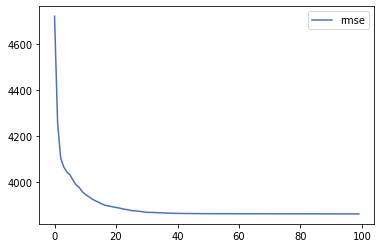

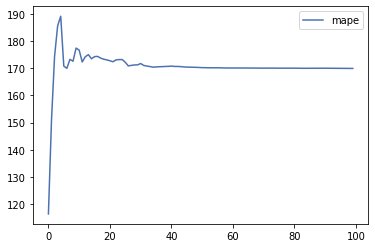

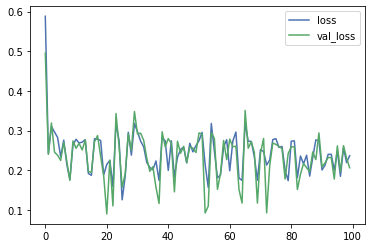

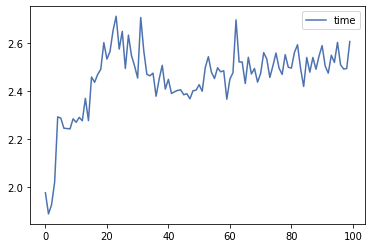

In [27]:
plt.plot(range(len(rmse_record)), rmse_record, label = 'rmse')
plt.legend()
plt.show()

plt.plot(range(len(mape_record)), mape_record, label = 'mape')
plt.legend()
plt.show()

plt.plot(range(len(loss_record)), loss_record, label = 'loss')
plt.plot(range(len(val_loss_record)), val_loss_record, label = 'val_loss')
plt.legend()
plt.show()

plt.plot(range(len(time_record)), time_record, label = 'time')
plt.legend()
plt.show()

In [28]:
model.eval()
# model_defect.eval()
## Inverse Normalize 
y_test_pred = scaler_kwh.inverse_transform(model(X_test).cpu().detach().numpy())
# y_test_pred_defect = scaler_kwh.inverse_transform(model_defect(X_test).cpu().detach().numpy())
y_test_obs = scaler_kwh.inverse_transform(y_test)

print('The root mean squared error of the model is ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)) +
      '\nThe MAPE of the model is ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)))

print('The defect root mean squared error of the model is ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred_defect)),2)) +
      '\nThe defect MAPE of the model is ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred_defect),2)))

AttributeError: 'list' object has no attribute 'size'

Text(0, 0.5, 'kWh')

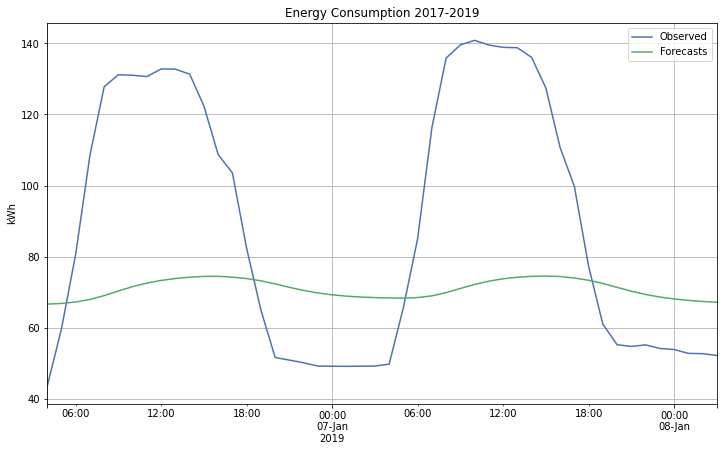

In [29]:
test_id = 1

scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts.loc[ts['client_id']==test_id][["kWh"]])
y_pred = scaler_kwh.inverse_transform(model(X_ts[test_id]).cpu().detach().numpy())
# y_pred_defect = scaler_kwh.inverse_transform(model_defect(X_ts[0]).cpu().detach().numpy())
y_obs = scaler_kwh.inverse_transform(y_ts[test_id].cpu().numpy())

pred_df = pd.DataFrame(y_pred,index = ts.index[-len(y_pred):],columns = ["kWh"])
# pred_df_defect = pd.DataFrame(y_pred_defect, index = ts.index[-len(y_pred_defect):],columns = ["kWh"])
obs_df = pd.DataFrame(y_obs,index = ts.index[-len(y_pred):],columns = ["kWh"])

fig, ax = plt.subplots()
plot_df = pd.concat([obs_df[:48],pred_df[:48]],axis=1)
# plot_df_defect = pd.concat([pred_df_defect],axis=1)
plot_df.plot(ax=ax,figsize=(12,7),style = '-', grid=True)
# plot_df_defect.plot(ax=ax,figsize=(12,7),style = 'o', grid=True)
# ax.legend(["Defect","Observed", "Forecasts"])
ax.legend(["Observed", "Forecasts"])
ax.set_title("Energy Consumption 2017-2019")
ax.set_ylabel("kWh")

测agg

Text(0, 0.5, 'kWh')

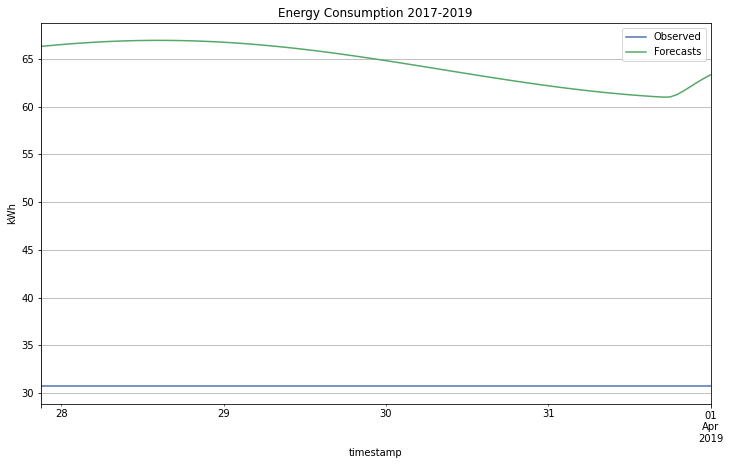

In [51]:
y_pred = scaler_kwh.inverse_transform(model(X_total[:100]).cpu().detach().numpy())
y_obs = scaler_kwh.inverse_transform(y_total[:100].cpu().numpy())

pred_df = pd.DataFrame(y_pred,index = ts_total.index[-len(y_pred):],columns = ["kWh"])
obs_df = pd.DataFrame(y_obs,index = ts_total.index[-len(y_pred):],columns = ["kWh"])

fig, ax = plt.subplots()
plot_df = pd.concat([obs_df,pred_df],axis=1)
plot_df.plot(ax=ax,figsize=(12,7),style = '-', grid=True)
ax.legend(['Observed', "Forecasts"])
ax.set_title("Energy Consumption 2017-2019")
ax.set_ylabel("kWh")